Tools used: 
- sra-tools https://github.com/ncbi/sra-tools 
- seqtk https://github.com/lh3/seqtk
- colord (original) https://github.com/refresh-bio/CoLoRd ; compiled with `MEASURE_THREADS_TIMES` defined
- colord (partial compression - only for slightly more convenient parsing) https://gitee.com/MGI-EU-AF/colord-partial-compression
- pandas, matplotlib, tqdm... 

# Download data from SRA
ecoli ONT sequencing with different coverage

search query: (e.coli[Organism]) AND "oxford nanopore"[Platform] 

- https://www.ncbi.nlm.nih.gov/sra/SRX18997756[accn] 1.7 Gb

In [2]:
import os
import time
import subprocess as sp
from collections import OrderedDict
from tqdm import tqdm

from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
mkdir -p data

In [4]:
link = 'https://www.ncbi.nlm.nih.gov/sra/SRX18997756[accn]'
accn = link.split('/')[-1].rstrip().removesuffix('[accn]') 
accn

'SRX18997756'

In [8]:
data_folder = 'data/'

filename = data_folder + accn + ".fastq"
if not os.path.isfile(filename):
#     pr = run(['fasterq-dump', accn])
    pr = sp.Popen(['fasterq-dump', accn], cwd=data_folder)
    pr.wait()

2023-02-20T15:50:49 fasterq-dump.2.9.1 sys: connection failed while opening file within cryptographic module - mbedtls_ssl_handshake returned -9984 ( X509 - Certificate verification failed, e.g. CRL, CA or signature check failed )
2023-02-20T15:50:49 fasterq-dump.2.9.1 sys: mbedtls_ssl_get_verify_result returned 0x4008 (  !! The certificate is not correctly signed by the trusted CA  !! The certificate is signed with an unacceptable hash.  )
2023-02-20T15:50:49 fasterq-dump.2.9.1 sys: connection failed while opening file within cryptographic module - ktls_handshake failed while accessing '130.14.29.110' from '192.168.0.108'
2023-02-20T15:50:49 fasterq-dump.2.9.1 sys: connection failed while opening file within cryptographic module - Failed to create TLS stream for 'www.ncbi.nlm.nih.gov' (130.14.29.110) from '192.168.0.108'
2023-02-20T15:50:49 fasterq-dump.2.9.1 err: invalid accession 'SRX18997756'


In [7]:
def check_download_finish(data_folder):
    for file in os.listdir(data_folder):
        if '.tmp.' in file:
            return False
    return True

nsec = 30
while not check_download_finish(data_folder):
    time.sleep(nsec*1000)

# Subsample `.fastq` file

In [24]:
SEED = 28

ori_cov = 431.112909
cov_to_check = [1, 5, 10, 25, 50, 100, 150, 200, 250, 300, 350, 400]
fractions = [round(cov / ori_cov, 3) for cov in cov_to_check]
filenames = []

for i, (cov, fr) in tqdm(enumerate(zip(cov_to_check, fractions))):
    fn = filename.removesuffix('.fastq') + f"-subs-cov-{cov}.fastq"
    
    if not os.path.isfile(fn):
        cmd = f"seqtk seq -f {fr} -s {SEED} {filename} > {fn}"
        sp.run(cmd, check=True, shell=True)
    
    filenames.append(fn)
    
filenames.append(filename)

12it [00:27,  2.27s/it]


In [29]:
! ls -lhS data/${filename.removesuffix('.fastq')}*.fastq

-rw-r--r-- 1 iam28th wheel 3.8G Feb 14 21:21 data//SRX18997756.fastq
-rw-r--r-- 1 iam28th wheel 3.5G Feb 15 10:43 data//SRX18997756-subs-cov-400.fastq
-rw-r--r-- 1 iam28th wheel 3.1G Feb 15 10:43 data//SRX18997756-subs-cov-350.fastq
-rw-r--r-- 1 iam28th wheel 2.6G Feb 15 10:43 data//SRX18997756-subs-cov-300.fastq
-rw-r--r-- 1 iam28th wheel 2.2G Feb 15 10:43 data//SRX18997756-subs-cov-250.fastq
-rw-r--r-- 1 iam28th wheel 1.8G Feb 15 10:43 data//SRX18997756-subs-cov-200.fastq
-rw-r--r-- 1 iam28th wheel 1.4G Feb 15 10:43 data//SRX18997756-subs-cov-150.fastq
-rw-r--r-- 1 iam28th wheel 886M Feb 15 10:43 data//SRX18997756-subs-cov-100.fastq
-rw-r--r-- 1 iam28th wheel 444M Feb 15 10:43 data//SRX18997756-subs-cov-50.fastq
-rw-r--r-- 1 iam28th wheel 222M Feb 15 10:43 data//SRX18997756-subs-cov-25.fastq
-rw-r--r-- 1 iam28th wheel  88M Feb 15 10:43 data//SRX18997756-subs-cov-10.fastq
-rw-r--r-- 1 iam28th wheel  46M Feb 15 10:43 data//SRX18997756-subs-cov-5.fastq
-rw-r--r-- 1 iam28th wheel 7.6M Fe

# Generate `.fasta` files

In [35]:
fastas = []

for fastq in tqdm(filenames):
    fasta = fastq.removesuffix('.fastq') + '.fasta'
    fastas.append(fasta)
    
    if not os.path.isfile(fasta):
        cmd = f"seqtk seq -A {fastq} > {fasta}"
        sp.run(cmd, shell=True, check=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:23<00:00,  1.82s/it]


In [37]:
! ls -lhS data/${filename.removesuffix('.fastq')}*.fasta

-rw-r--r-- 1 iam28th wheel 1.9G Feb 14 21:22 data//SRX18997756.fasta
-rw-r--r-- 1 iam28th wheel 1.8G Feb 15 10:50 data//SRX18997756-subs-cov-400.fasta
-rw-r--r-- 1 iam28th wheel 1.6G Feb 15 10:50 data//SRX18997756-subs-cov-350.fasta
-rw-r--r-- 1 iam28th wheel 1.4G Feb 15 10:50 data//SRX18997756-subs-cov-300.fasta
-rw-r--r-- 1 iam28th wheel 1.1G Feb 15 10:50 data//SRX18997756-subs-cov-250.fasta
-rw-r--r-- 1 iam28th wheel 894M Feb 15 10:50 data//SRX18997756-subs-cov-200.fasta
-rw-r--r-- 1 iam28th wheel 669M Feb 15 10:50 data//SRX18997756-subs-cov-150.fasta
-rw-r--r-- 1 iam28th wheel 444M Feb 15 10:50 data//SRX18997756-subs-cov-100.fasta
-rw-r--r-- 1 iam28th wheel 223M Feb 15 10:50 data//SRX18997756-subs-cov-50.fasta
-rw-r--r-- 1 iam28th wheel 112M Feb 15 10:50 data//SRX18997756-subs-cov-25.fasta
-rw-r--r-- 1 iam28th wheel  44M Feb 15 10:50 data//SRX18997756-subs-cov-10.fasta
-rw-r--r-- 1 iam28th wheel  23M Feb 15 10:50 data//SRX18997756-subs-cov-5.fasta
-rw-r--r-- 1 iam28th wheel 3.8M Fe

# Calculate coverage
https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100269

E.coli genome sizes may vary, so assuming genome size from the link above.

In [36]:
GENOME_SIZE = 4639221

coverages = []
for filename in tqdm(filenames):
    
    seqtk = sp.Popen(['seqtk', 'fqchk', filename], stdout=sp.PIPE)  # probably faster way exists...
    head = sp.check_output(['head', '-n', '3'], stdin=seqtk.stdout).decode('utf8')

    nbases = int(head.splitlines()[-1].split()[1])
    coverages.append(nbases / GENOME_SIZE)
print(*filenames, sep='\t')
print(*coverages, sep='\t')

100%|███████████████████████████████████████████████████████████████████████████████████████████| 13/13 [02:03<00:00,  9.47s/it]

data/SRX18997756-subs-cov-1.fastq	data/SRX18997756-subs-cov-5.fastq	data/SRX18997756-subs-cov-10.fastq	data/SRX18997756-subs-cov-25.fastq	data/SRX18997756-subs-cov-50.fastq	data/SRX18997756-subs-cov-100.fastq	data/SRX18997756-subs-cov-150.fastq	data/SRX18997756-subs-cov-200.fastq	data/SRX18997756-subs-cov-250.fastq	data/SRX18997756-subs-cov-300.fastq	data/SRX18997756-subs-cov-350.fastq	data/SRX18997756-subs-cov-400.fastq	data/SRX18997756.fastq
0.8542703613386816	5.125886867644374	9.816036787210612	24.97999168394866	50.04330037305832	99.77309962168218	150.42968054334983	200.87865160982847	250.320419958437	300.089957990792	350.7352488704461	400.4336074957412	431.1129090422724


...close enough

# Run CoLoRd for all files

In [1]:
logs = []
CLRD="../MGI/colord-partial-compression/bin/colord"

# fastq
for inp in tqdm(filenames):
    out = inp.removesuffix('.fastq') + '.ont-default'
    log = inp.removesuffix('.fastq') + '.ont-default.log'
    
    logs.append(log)
    
    threads_times = dict()
    section_cr = dict()
    
    if not os.path.isfile(log):
        cmd = [CLRD, 'compress-ont', inp, out, '--verbose', '--section', 'all', '2>', log]
        cmd = ' '.join(cmd)
        pr = sp.run(cmd, shell=True, capture_output=True, check=True)
        
# fasta
logs_fasta = []
for inp in tqdm(fastas):
    out = inp + '.ont-default'
    log = inp + '.ont-default.log'
    
    logs_fasta.append(log)
    
    threads_times = dict()
    section_cr = dict()
    
    if not os.path.isfile(log):
        cmd = ["colord-ori", 'compress-ont', inp, out, '--verbose', '2>', log]
        cmd = ' '.join(cmd)
        pr = sp.run(cmd, shell=True, capture_output=True, check=True)

NameError: name 'tqdm' is not defined

# Calculate running time and CR

In [46]:
l_threads_times = []
l_section_cr = []

# fastq
for i, inp in tqdm(enumerate(filenames)):
    log = logs[i]
    
    threads_times = OrderedDict()
    section_cr = OrderedDict()
    
    cmd = ['grep -A 26 "Threads times summary"', log]
    cmd = ' '.join(cmd)
    pr = sp.run(cmd, shell=True, capture_output=True, check=True)
    output = pr.stdout.decode('utf8').splitlines()
    
    thr = output[1:13]
    thr.append(output[-5])  # total time
    thr[-1] = thr[-1].rstrip('s')
    
    for line in thr:
        section, times = line.split(':')
        section = section.strip().replace('sorted', 'sum')
        times = [float(x) for x in times.split()]
        
        threads_times[section] = sum(times)
    
    l_threads_times.append(threads_times)
        
    cr = output[-3:]
    for line in cr:
        section, ori, compr = line.split()
        ori = int(ori)
        compr = int(compr)
        section_cr[section] = ori / compr
    l_section_cr.append(section_cr)
    
# fasta
l_tt_fasta = []
for log in tqdm(logs_fasta):
    with open(log, 'r') as f:
        # print(*f.readlines())
        for line in f:
            if "Total time" in line:
                tt = float(line.split(' : ')[1].rstrip().rstrip('s'))
                l_tt_fasta.append(tt)
                break

13it [00:00, 237.22it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 6423.13it/s]


In [47]:
l_threads_times[0]

OrderedDict([('reader', 0.039516),
             ('similarity finder', 0.000821),
             ('similarity finder internal (sum)', 0.05968600000000001),
             ('mean similarity finder internal', 0.00746075),
             ('encoders (sum)', 0.9245190000000001),
             ('mean encoders', 0.132074),
             ('encoders wait on queue (sum)', 0.3597123),
             ('mean encoders wait on queue', 0.0513875),
             ('entr. compr.', 0.067158),
             ('entr. compr. qual.', 0.061316),
             ('entr. compr. header', 0.058205),
             ('store result', 0.000109),
             ('Total time', 1.35352)])

In [49]:
df = dict()
columns = ['Coverage', 'CR_dna', 'CR_qual', 'CR_header']

for k, v in l_threads_times[0].items():
    columns.append('Time ' + k if not k[0].isupper() else k)
    
io_threads = ['reader', 'store result']
entr_threads = [k for k in l_threads_times[0] if k.startswith('entr.')]
graph_threads = [k for k in l_threads_times[0] if (k.startswith('similarity') or k.startswith('encoders'))]

columns.extend(['Time - IO', 
                'Time - Sim.Graph', 
                'Time - RangeCoding'
               ])
columns.append('Total time (fasta)')

for i, fn in enumerate(filenames):
    fn = fn.removesuffix('.fastq')
    
    df[fn] = [
        coverages[i],
        l_section_cr[i]['dna'],
        l_section_cr[i]['qual'],
        l_section_cr[i]['header'],
    ]
    
    for k, v in l_threads_times[i].items():
        df[fn].append(v)
        
    df[fn].extend([
        sum(l_threads_times[i][thr] for thr in io_threads),
        sum(l_threads_times[i][thr] for thr in graph_threads),
        sum(l_threads_times[i][thr] for thr in entr_threads),
    ])
    df[fn].append(l_tt_fasta[i])
    
        
df = pd.DataFrame(df).T
df.columns = columns
df.sort_values(by='Coverage', inplace=True)
df

,Coverage,CR_dna,CR_qual,CR_header,Time reader,Time similarity finder,Time similarity finder internal (sum),Time mean similarity finder internal,Time encoders (sum),Time mean encoders,...,Time mean encoders wait on queue,Time entr. compr.,Time entr. compr. qual.,Time entr. compr. header,Time store result,Total time,Time - IO,Time - Sim.Graph,Time - RangeCoding,Total time (fasta)
data/SRX18997756-subs-cov-1,0.854270,4.168945,7.235338,6.341052,0.039516,0.000821,0.059686,0.007461,0.924519,0.132074,...,0.051388,0.067158,0.061316,0.058205,0.000109,1.35352,0.039625,1.344738,0.186679,1.35191
data/SRX18997756-subs-cov-5,5.125887,6.048467,7.415017,8.004320,0.168136,0.037148,0.360212,0.045026,8.901845,1.271690,...,0.147375,0.401988,0.360071,0.065721,0.000099,2.82066,0.168235,10.330828,0.827780,2.90067
data/SRX18997756-subs-cov-10,9.816037,8.009431,7.446680,8.547314,0.350030,0.207427,0.813706,0.101713,18.491650,2.641670,...,0.175342,0.936269,0.853228,0.065256,0.000004,4.33976,0.350034,20.740177,1.854753,4.18394
data/SRX18997756-subs-cov-25,24.979992,10.161134,7.467652,9.345462,0.908895,0.789406,2.441732,0.305217,58.060460,8.294350,...,0.192564,2.099890,3.298430,0.079880,0.000009,10.80650,0.908904,62.639550,5.478200,10.67250
data/SRX18997756-subs-cov-50,50.043300,11.156190,7.477783,10.008508,1.794040,1.870130,5.138302,0.642288,127.705600,18.243700,...,0.206866,4.092520,5.663020,0.087212,0.000009,22.17850,1.794049,136.162097,9.842752,23.23220
data/SRX18997756-subs-cov-100,99.773100,12.288108,7.483718,10.916449,3.731440,4.740230,10.926840,1.365860,319.314900,45.616400,...,0.217996,8.126560,11.982400,0.102911,0.000004,52.96320,3.731444,336.507944,20.211871,52.42990
data/SRX18997756-subs-cov-150,150.429681,12.765788,7.485803,11.532219,5.805550,8.344820,17.087890,2.135990,543.196300,77.599500,...,0.239349,12.397500,18.372200,0.123324,0.000006,88.06480,5.805556,570.304453,30.893024,84.92320
data/SRX18997756-subs-cov-200,200.878652,13.247268,7.488289,11.963260,7.840960,12.689300,23.215710,2.901960,778.802000,111.257000,...,0.278011,16.049400,26.141700,0.149786,0.000010,125.09000,7.840970,816.653083,42.340886,121.51200
data/SRX18997756-subs-cov-250,250.320420,13.416445,7.489177,12.242900,9.807870,17.112800,29.878800,3.734850,946.338000,135.191000,...,0.273277,19.804500,31.390300,0.167350,0.000008,151.45000,9.807878,995.242537,51.362150,147.44700
data/SRX18997756-subs-cov-300,300.089958,13.581523,7.490071,12.456138,11.694500,22.456200,36.342440,4.542810,1173.434000,167.634000,...,0.300475,23.453900,38.069300,0.191025,0.000005,186.45400,11.694505,1234.335967,61.714225,182.50800


# Visualizations...

In [56]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SCATTER_S = 50

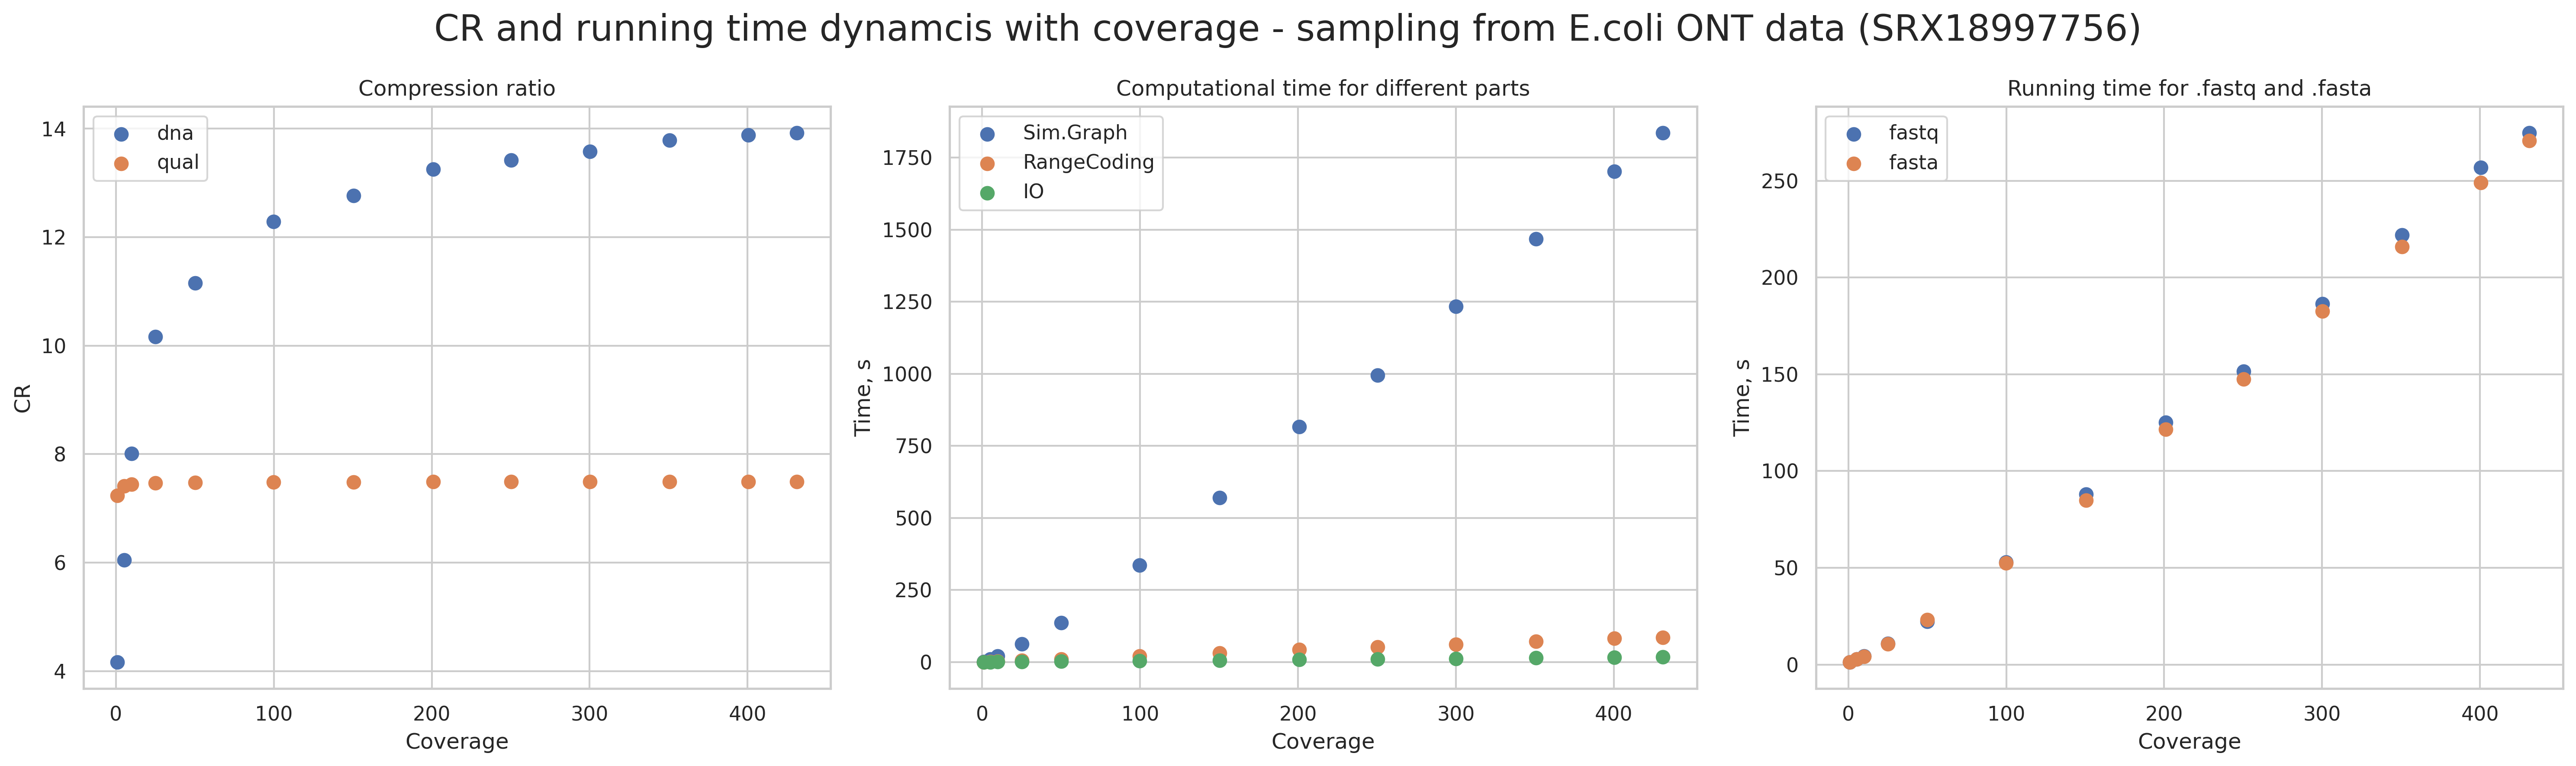

In [114]:
# fig 1 : coverage vs CR and time
fig, axs = plt.subplots(1, 3, figsize=(20, 6), dpi=300)
fig.suptitle('CR and running time dynamcis with coverage - sampling from E.coli ONT data (SRX18997756)')
    
ax = axs[0]
for section in ('dna', 'qual'):
    x = df['Coverage']
    y = df['CR_' + section]
    ax.scatter(x, y, label=section, s=SCATTER_S)
ax.set_title('Compression ratio')
ax.set_ylabel('CR')

# fig 2 : coverage vs computational time
ax = axs[1]
ax.set_ylabel('Computational time')
for section in ('Sim.Graph', 'RangeCoding', 'IO'):
    x = df['Coverage']
    y = df['Time - ' + section]
    ax.scatter(x, y, label=section, s=SCATTER_S)
ax.set_title('Computational time for different parts')
ax.set_ylabel('Time, s')
    
# fig 3 : coverage vs real time for fasta and fastq
ax = axs[2]
for fmt in ('fastq', 'fasta'):
    x = df['Coverage']
    if fmt == 'fastq':
        y = df['Total time']
    else:
        y = df['Total time (fasta)']
    ax.scatter(x, y, label=fmt, s=SCATTER_S)
ax.set_ylabel('Time, s')
ax.set_title('Running time for .fastq and .fasta')

for ax in axs:
    ax.legend();
    # ax.grid();
    ax.set_xlabel('Coverage')
    
fig.tight_layout();

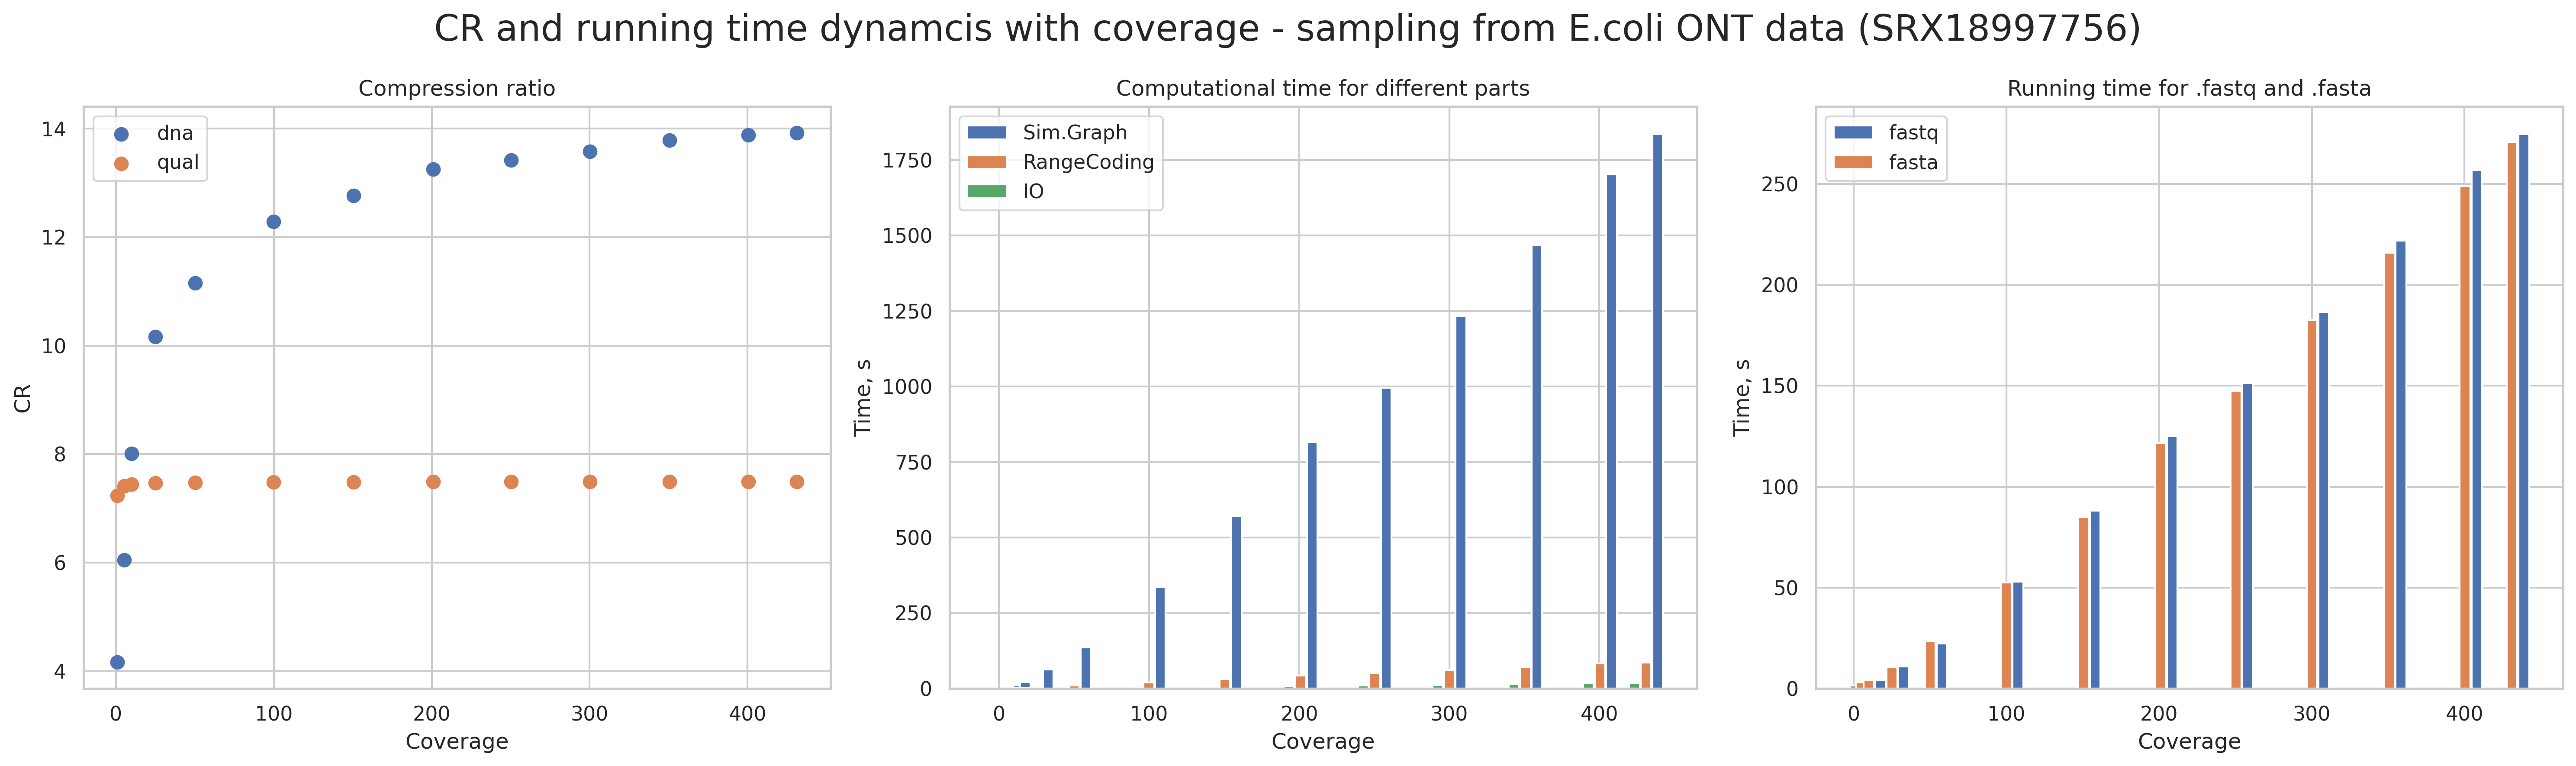

In [115]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6), dpi=300)
fig.suptitle('CR and running time dynamcis with coverage - sampling from E.coli ONT data (SRX18997756)')

WIDTH = 7
    
# ax = axs[0]
# for section in ('qual', 'dna'):
#     x = df['Coverage']
#     y = df['CR_' + section]
#     if section == 'dna':
#         ax.bar(x + WIDTH * 1.1, y, label=section, width=WIDTH)
#     if section == 'qual':
#         ax.bar(x, y, label=section, width=WIDTH)
# ax.set_title('Compression ratio')
# ax.set_ylabel('CR')
ax = axs[0]
for section in ('dna', 'qual'):
    x = df['Coverage']
    y = df['CR_' + section]
    ax.scatter(x, y, label=section, s=SCATTER_S)
ax.set_title('Compression ratio')
ax.set_ylabel('CR')
        
# fig 2 : coverage vs computational time
ax = axs[1]
for section in ('Sim.Graph', 'RangeCoding', 'IO'):
    x = df['Coverage']
    y = df['Time - ' + section]
    shift = 0
    if section == "IO":
        shift = -WIDTH * 1.1
    elif section == "Sim.Graph":
        shift = WIDTH * 1.1
    ax.bar(x + shift, y, label=section, width=WIDTH)
ax.set_title('Computational time for different parts')
ax.set_ylabel('Time, s')
    
# fig 3 : coverage vs real time for fasta and fastq
ax = axs[2]
for fmt in ('fastq', 'fasta'):
    x = df['Coverage']
    if fmt == 'fastq':
        y = df['Total time']
        ax.bar(x + WIDTH * 1.1, y, label=fmt, width=WIDTH)
    else:
        y = df['Total time (fasta)']
        ax.bar(x, y, label=fmt, width=WIDTH)
ax.set_ylabel('Time, s')
ax.set_title('Running time for .fastq and .fasta')

for ax in axs:
    ax.legend();
    # ax.grid();
    ax.set_xlabel('Coverage')
    
fig.tight_layout();